# Group 10 New York Housing Prices Machine Learning Model

> This is an artificial intelligence model from the AI3000R course in Information Technology and Information Systems program at University of South-Eastern Norway campus Hønefoss. This assignment is meant as a check to qualify us to be able to take the exam for this course.

# Jonas

Our model combines thousands of living spaces in the broader New York area, to make you have the best bet of getting a good place to live - for a decent sum, instead of being ravaged by the predatoric practices of New York landlords. Use our services for a relatively cheap buck, and save thousands in the long run!


In [134]:
# AI3000R
# Machine Learning Model Predicting House Prices in New York using Random Forest

# Import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

Now that we have imported the libraries we need for data analysis, we need some data these libraries can operate with. For example the `NY-House-Dataset.csv` from Nidula Elgiriyewithana on [Kaggle](https://www.kaggle.com/datasets/nelgiriyewithana/new-york-housing-market/data). Let's load it and `read_csv`. To check that it functions as intended, let's show the head of the file as well.

In [135]:
# Load data
df = pd.read_csv(r'NY-House-Dataset.csv')
print(df.head())

                                         BROKERTITLE                TYPE  \
0        Brokered by Douglas Elliman  -111 Fifth Ave      Condo for sale   
1                                Brokered by Serhant      Condo for sale   
2                             Brokered by Sowae Corp      House for sale   
3                                Brokered by COMPASS      Condo for sale   
4  Brokered by Sotheby's International Realty - E...  Townhouse for sale   

       PRICE  BEDS       BATH  PROPERTYSQFT  \
0     315000     2   2.000000        1400.0   
1  195000000     7  10.000000       17545.0   
2     260000     4   2.000000        2015.0   
3      69000     3   1.000000         445.0   
4   55000000     7   2.373861       14175.0   

                                             ADDRESS                    STATE  \
0                               2 E 55th St Unit 803       New York, NY 10022   
1  Central Park Tower Penthouse-217 W 57th New Yo...       New York, NY 10019   
2                

For our model, we only select the features what we are actually going to train the model on. Let's not waste resources. We define this by making a list of which columns we want to get into the `feature_columns` variable.

In [136]:
# Select features
feature_columns = ['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE']
target_column = 'PRICE'

# Lucas

Then, we need to clean the data. We wan't to remove `null`-values, statistical outliers, and so on...

In [137]:
# Clean data
df_clean = df[feature_columns + [target_column]].dropna()
df_clean = df_clean[(df_clean['PRICE'] > 10000) & (df_clean['PRICE'] < 10000000)]
df_clean = df_clean[df_clean['PROPERTYSQFT'] > 0]

From our `NY-House-Dataset.csv` we register a lot of cells with a value of $2184.207862$ square feet. Let's remove those from our model as well, and check the shape of our dataset.

In [138]:
# Remove fake sqft
fake_sqft = 2184.207862
print(f"Properties with fake sqft: {(df_clean['PROPERTYSQFT'] == fake_sqft).sum()}")
print(f"Percentage: {(df_clean['PROPERTYSQFT'] == fake_sqft).mean() * 100:.1f}%")
df_clean = df_clean[df_clean['PROPERTYSQFT'] != fake_sqft]

print(f"Dataset shape: {df_clean.shape}")

# Save for plots
df_for_plots = df_clean.copy()


Properties with fake sqft: 1578
Percentage: 34.0%
Dataset shape: (3060, 7)


OK, now that the dataset is cleaned, let's get on with feature engineering.

In [139]:
# FEATURE ENGINEERING
df_clean['BEDS_BATH'] = df_clean['BEDS'] * df_clean['BATH']
df_clean['SQFT_PER_ROOM'] = df_clean['PROPERTYSQFT'] / (df_clean['BEDS'] + df_clean['BATH'] + 1)  # +1 to avoid division by zero
df_clean['LOG_SQFT'] = np.log1p(df_clean['PROPERTYSQFT'])

We think that for price estimates, the type of housing will influence this. But in our dataset, the `TYPE` column is in text format, so we need to encode it to numbers. One of our algorithms is __Random Forest__ and Random Forest can't handle text.

In [140]:
# ENCODE TYPE (Random Forest can't handle text)
le = LabelEncoder()
df_clean['TYPE_ENCODED'] = le.fit_transform(df_clean['TYPE'])

Because of the reencoding, we will need to update the feature columns.

In [141]:
# Update feature columns
feature_columns = ['TYPE_ENCODED', 'BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE', 
                  'BEDS_BATH', 'SQFT_PER_ROOM', 'LOG_SQFT']

OK. Let's get on to splitting the test data and the training data. 

In [142]:
# Prepare features and target
X = df_clean[feature_columns]
y = df_clean[target_column]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kristian

We will test four different algorithms at once. So, we should scale the features using `StandardScaler`. It is not neccessary for the Random Forest algorithm, but it is good practice to scale the features. 

In [143]:
# Scale features (optional for Random Forest, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [144]:
# ============= TRAIN MULTIPLE MODELS =============

print("\n" + "="*50)
print("COMPARING MODELS")
print("="*50)


COMPARING MODELS


# Comparing models

The first model is based on the `Linear Regression` algorithm.

In [145]:
# 1. Linear Regression (baseline)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_pred)
print(f"\nLinear Regression R²: {lr_r2:.4f}")


Linear Regression R²: 0.4403


The second model is based on the `Random Forest` algorithm.

In [146]:
# 2. Random Forest (usually best)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train, y_train)  # Don't need scaling for RF
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f"Random Forest R²: {rf_r2:.4f}, RMSE: ${rf_rmse:,.0f}")

Random Forest R²: 0.8140, RMSE: $622,093


The third one is called `Gradient Boosting`.

In [147]:
# 3. Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, gb_pred)
print(f"Gradient Boosting R²: {gb_r2:.4f}")

Gradient Boosting R²: 0.7792


The fourth one is a variant of `GradientBoosting` called XGBoost.

In [148]:
# 4. XGBoost (often the winner)
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"XGBoost R²: {xgb_r2:.4f}")

XGBoost R²: 0.7937


So, which one was best? Which had the highest accuracy, the highest $R^2$ score?

In [149]:
# ============= USE BEST MODEL (probably Random Forest) =============

print("\n" + "="*50)
print("DETAILED METRICS FOR RANDOM FOREST")
print("="*50)

# Calculate detailed metrics
mae = mean_absolute_error(y_test, rf_pred)
mape = mean_absolute_percentage_error(y_test, rf_pred)
within_10_percent = np.mean(np.abs(rf_pred - y_test) / y_test <= 0.10) * 100
within_20_percent = np.mean(np.abs(rf_pred - y_test) / y_test <= 0.20) * 100

print(f"\nR² Score: {rf_r2:.4f}")
print(f"Root Mean Square Error: ${rf_rmse:,.0f}")
print(f"Mean Absolute Error: ${mae:,.0f}")
print(f"Mean Absolute Percent Error: {mape:.2%}")
print(f"Within 10% of actual: {within_10_percent:.1f}%")
print(f"Within 20% of actual: {within_20_percent:.1f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


DETAILED METRICS FOR RANDOM FOREST

R² Score: 0.8140
Root Mean Square Error: $622,093
Mean Absolute Error: $328,994
Mean Absolute Percent Error: 28.24%
Within 10% of actual: 31.4%
Within 20% of actual: 57.4%

Feature Importance:
         Feature  Importance
3   PROPERTYSQFT    0.234886
0   TYPE_ENCODED    0.211652
8       LOG_SQFT    0.205404
5      LONGITUDE    0.138292
4       LATITUDE    0.101842
7  SQFT_PER_ROOM    0.065695
2           BATH    0.023387
6      BEDS_BATH    0.012030
1           BEDS    0.006812


- Linear Regression R²: 0.4403
- Random Forest R²: 0.8140
- Gradient Boosting R²: 0.7792
- XGBoost R²: 0.7937

So, from our model executions, we can see that the algorithm trained on our dataset that had the highest $R^2$ value was the `Random Forest` algorithm which came out with a $R^2$ score of $0.8140$. This means that $81.40 \%$ of the cases can be explained with our model. 

# Kenneth

Let's get on with some visualizations.

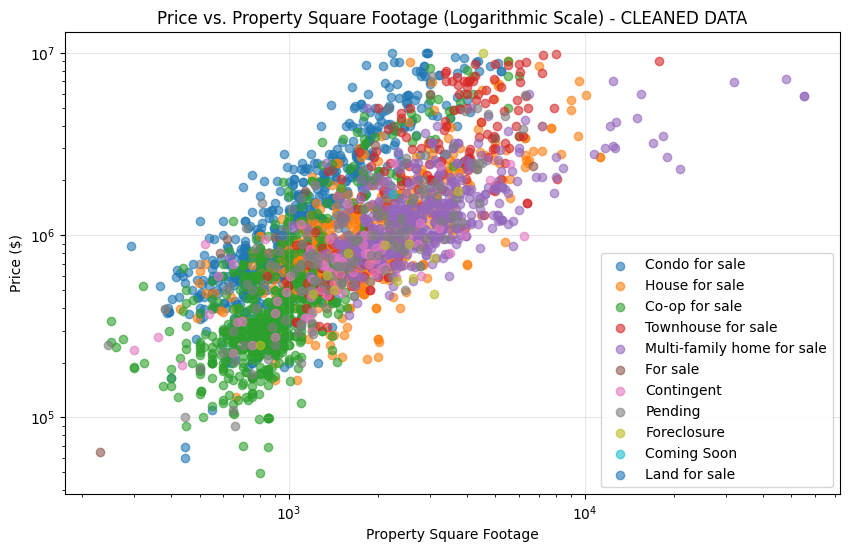

In [150]:
# ============= ALL PLOTS =============

# 1. Price vs Property Square Footage (by Type)
plt.figure(figsize=(10,6))
for house_type in df_for_plots['TYPE'].unique():
    subset = df_for_plots[df_for_plots['TYPE'] == house_type]
    plt.scatter(subset['PROPERTYSQFT'], subset['PRICE'], label=house_type, alpha=0.6)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Property Square Footage')
plt.ylabel('Price ($)')
plt.title('Price vs. Property Square Footage (Logarithmic Scale) - CLEANED DATA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

From this scatter plot we can see that the price estimates show distinct patterns by property type. The most notable groupings are:

__Co-op for sale__ (green): Forms the lowest price cluster, typically under $1M regardless of square footage, indicating the most affordable price-per-square-foot ratio.

__Multi-family home for sale__ (purple): Shows a wide range of square footage (1,000-10,000+ sqft) with correspondingly higher prices, but maintains reasonable value for larger properties.

__Condo for sale__ (blue): Demonstrates the highest price-per-square-foot ratio, with many properties exceeding $1M even at smaller sizes, making them the most expensive option relative to space provided.

The logarithmic scales reveal that while larger properties generally cost more, co-ops consistently offer the best value proposition, while condos command premium pricing regardless of size.

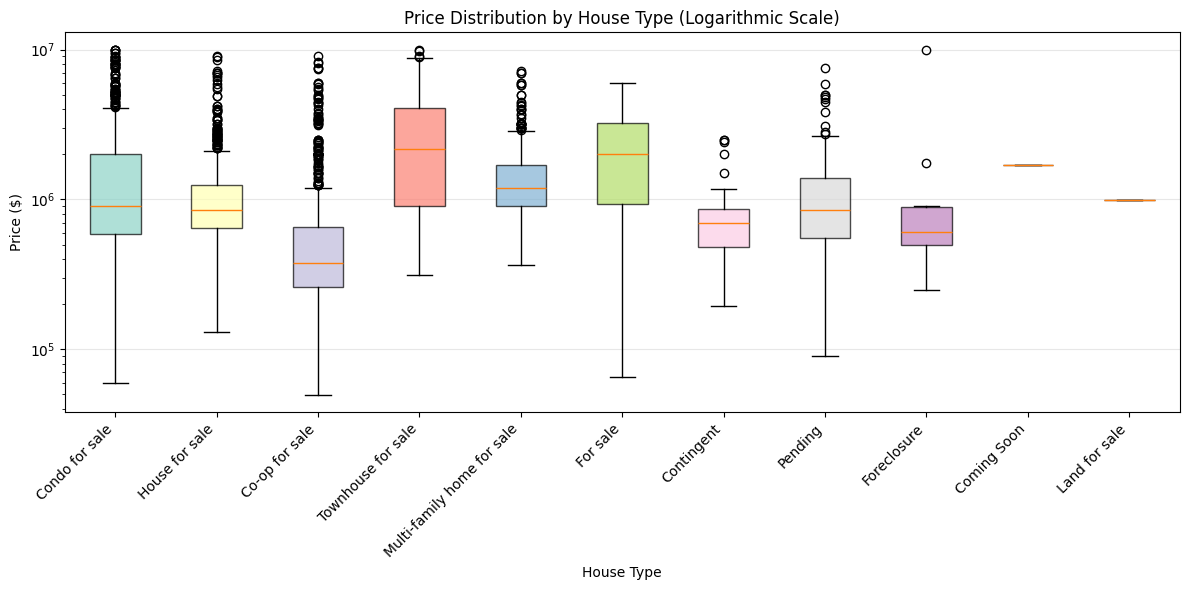

In [151]:
# 2. Price Distribution by House Type (Boxplot)
plt.figure(figsize=(12,6))
house_types = df_for_plots['TYPE'].unique()
price_data = [df_for_plots[df_for_plots['TYPE'] == t]['PRICE'] for t in house_types]

bp = plt.boxplot(price_data, tick_labels=house_types, patch_artist=True)
colors = plt.cm.Set3(np.linspace(0,1,len(house_types)))
for patch, color in zip(bp['boxes'],colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.yscale('log')
plt.xlabel('House Type')
plt.ylabel('Price ($)')
plt.title('Price Distribution by House Type (Logarithmic Scale)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


This box plots shows price distributions across different property types using a logarithmic scale, which is useful for handling the wide range of property values.

__Data characteristics__:
- Logarithmic y-axis ($10^5$ to $10^7$ handles extreme price variations)
- Multiple outliers visible as circles above whiskers
- Box plots show median (orange line), quartiles (box edges), and range (whiskers)

## Key observations

__Highest priced categories__:
- __Townhouse for sale__: Highest median price ($\$~2-3 \space \text million$), widest price range
- __For sale__: Second highest median
- __Condo for sale__ Third highest median 

__Mid-range categories__:
- __Multi-family home for sale__: Moderate median ($\$ ~1-2 \space \text million$)
- __House for sale__: Similar range to condos
- __Pending__: Lower median ($\$~800 \space \text k - 1 \space \text million$)

__Lower priced categories__:
- __Co-op for sale__: Lowest median ($\$~400 \space \text k - 500 \space \text k$)
- __Foreclosure__: Very low median ($\$~600 \space \text k - 700 \space \text k$)
- __Contingent__: Low median ($\$~700 \space \text k - 800 \space \text k$)


C:\Users\kmtve\AppData\Local\Temp\ipykernel_27120\2856428439.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(['$%dk' % (10**(t)/1000) if t < 6 else '$%dM' % (10**(t)/1e6) for t in cbar_ticks])


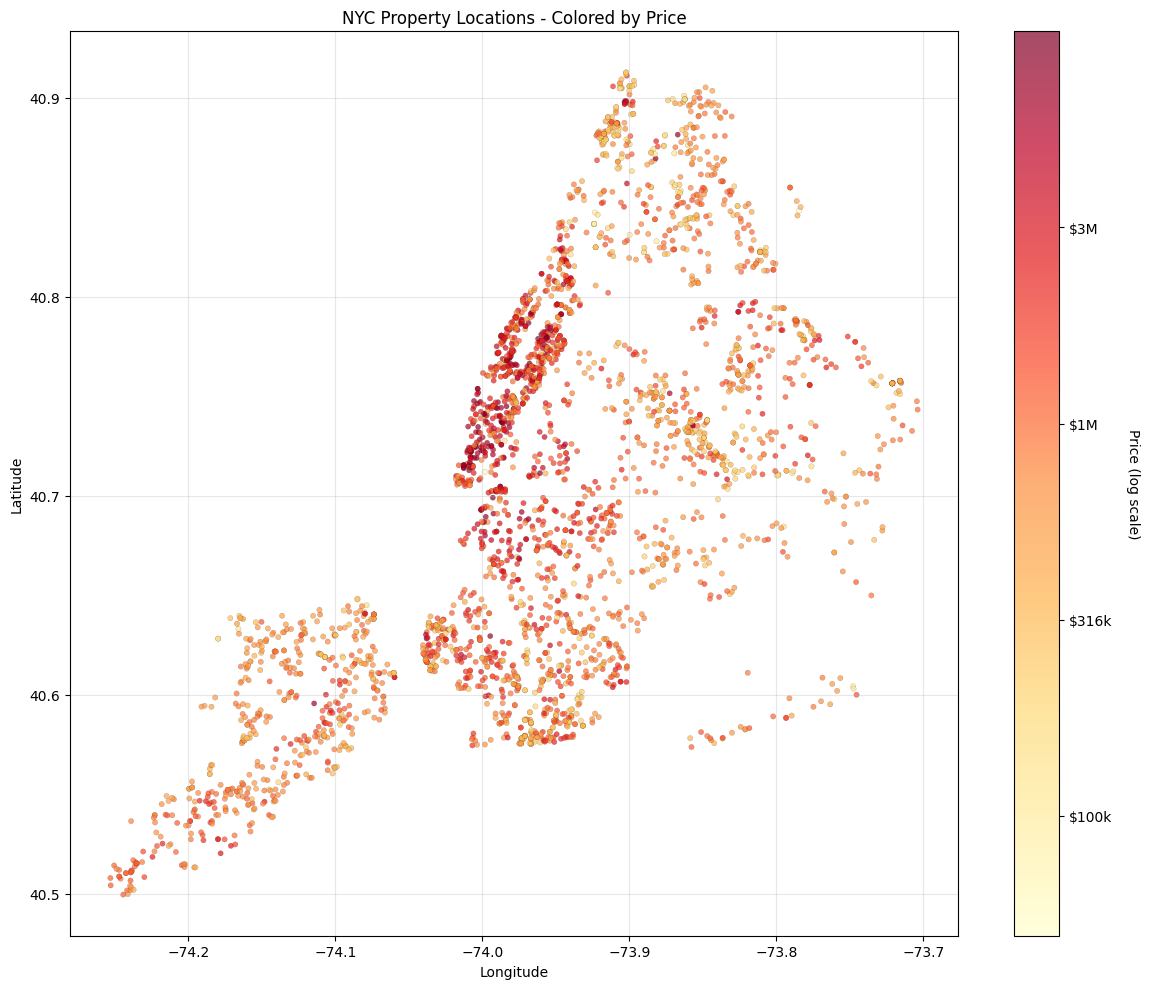

In [152]:
# 3. Geographic Location with Price Colors
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_for_plots['LONGITUDE'], 
                     df_for_plots['LATITUDE'], 
                     c=np.log10(df_for_plots['PRICE']),
                     cmap='YlOrRd',
                     alpha=0.7,
                     s=15,
                     edgecolors='black',
                     linewidth=0.1)

cbar = plt.colorbar(scatter)
cbar.set_label('Price (log scale)', rotation=270, labelpad=20)
# Fix colorbar labels to show actual prices
cbar_ticks = cbar.get_ticks()
cbar.set_ticklabels(['$%dk' % (10**(t)/1000) if t < 6 else '$%dM' % (10**(t)/1e6) for t in cbar_ticks])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC Property Locations - Colored by Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

> _Location, location, location_

This scatter plots maps property locations across New York City with color coding representing price levels on a logarithmic scale.

# Key findings

- Clear price gradient radiating outward from Manhattan
- Manhattan's linear geography creates distinct north-south price corridors
- Bridge/tunnel proximity affects outer borough pricing.
- Manhattan shows highest density and prices
- Clear geographic clustering by price tier
- Outer boroughs have more scattered, lower-priced properties
- Transportation corridors likely influence price distributions

This visualization effectively demonstrates how location drives property values in NYC's complex real estate market. 



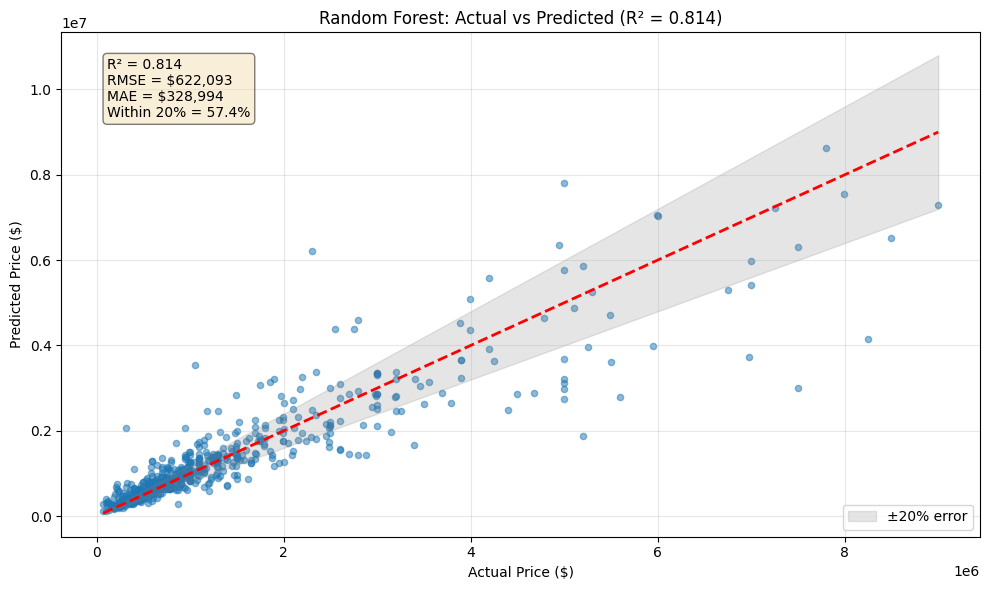

In [153]:
# 4. Actual vs Predicted (Random Forest)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Add error bands
plt.fill_between([y_test.min(), y_test.max()], 
                 [y_test.min()*0.8, y_test.max()*0.8], 
                 [y_test.min()*1.2, y_test.max()*1.2], 
                 alpha=0.2, color='gray', label='±20% error')

plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Random Forest: Actual vs Predicted (R² = {rf_r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text with metrics
textstr = f'R² = {rf_r2:.3f}\nRMSE = ${rf_rmse:,.0f}\nMAE = ${mae:,.0f}\nWithin 20% = {within_20_percent:.1f}%'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

This scatter plot evaluates a `Random Forest` regression model's performance for property price prediction, showing actual vs predicted values.

$R^2 = 0.814$: Model explains $81.4 \%$ of price variance (strong performance)
RMSE = $622,093: Avg prediction error
MAE = $328,994: Mean absolute error
Within 20% = 57.4%: Over half of predictions within 20% of actual price

- Model suitable for general price estimation
- Use with caution for properties $\gt \$ 4 \text M$
- 57.4% accuracy within 20% makes it useful for initial valuations

This `Random Forest` model demonstrates solid predictive capability for NYC real estate, with room for refinement in the luxury market segments. This customer segment is not our target group anyway.

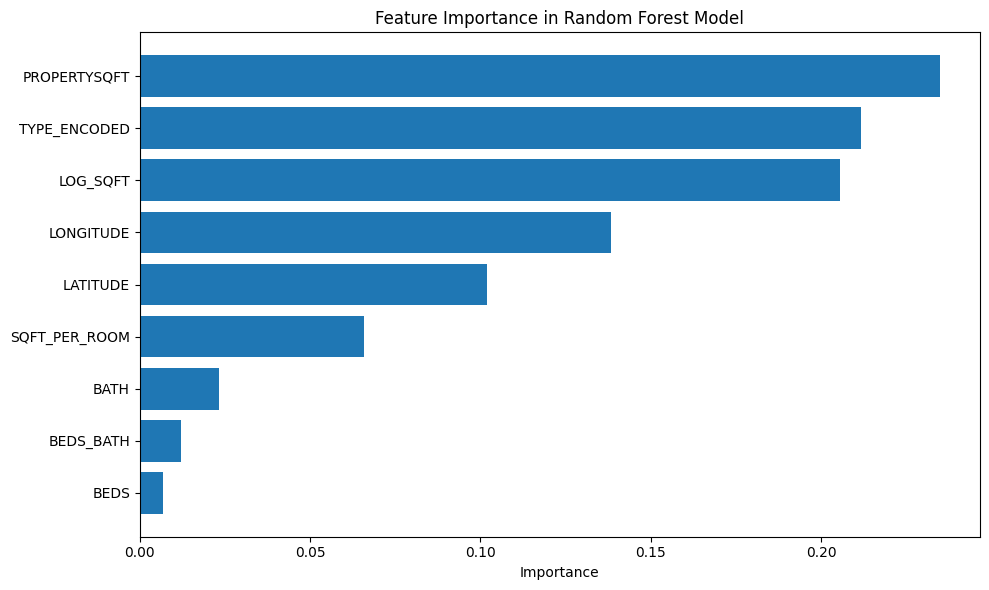

In [154]:
# 5. Feature Importance Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

From this we find that size matters. Size-based features dominate ($\textsf{PROPERTYSQFT} + \textsf{LOG\_SQFT} \approx 43\%$ combined importance). This validates the real estate axiom that in constrained markets like NYC, __space is the ultimate commodity__.

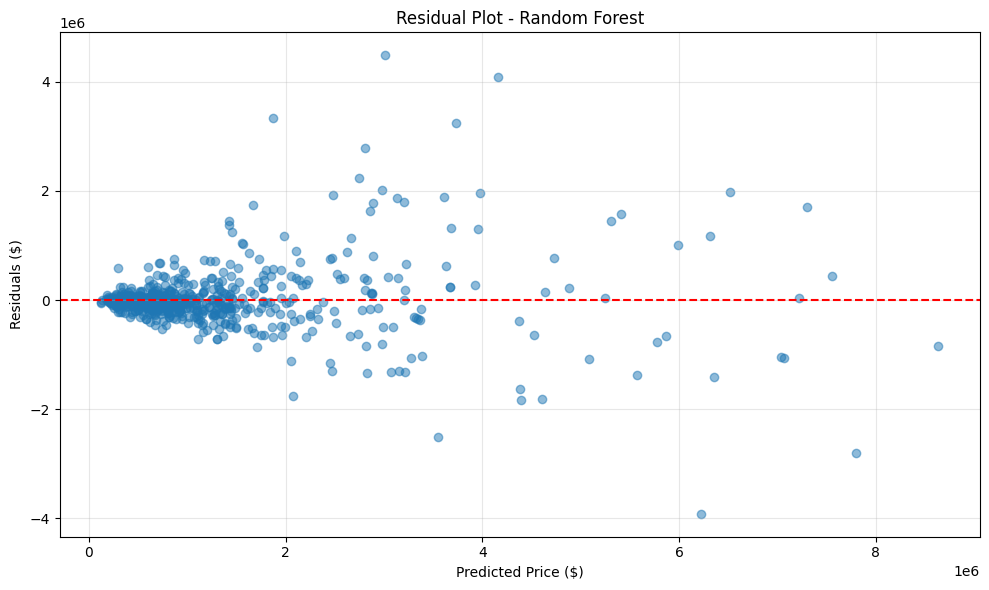

In [155]:
# 6. Residuals Plot (to check for patterns)
residuals = y_test - rf_pred
plt.figure(figsize=(10, 6))
plt.scatter(rf_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot - Random Forest')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This residual plot shows __prediction errors__ vs __predicted values__ for our `Random Forest` model.

__Residuals = Actual price - Predicted Price__
- __Positive residuals__: Model underestimated the price
- __Negative residuals__: Model overestimated the price
- __Red dashed line at y=0__: Perfect predictions (no error)

# Conclusions 

__Practical insights__:
- Model works well across most price ranges
- Larger errors occur for unique/outlier properties
- Lower-priced properties show more prediction uncertainty
- High-end properties ($>$6 \text M$) have fewer data points but reasonable errors

__Next steps__:
- Consider separate models for different price segments
- Investigate outliers for feature engineering opportunities
- Model is performing well overall - residuals show healthy randomness

This residual pattern indicates our Random Forest is __well-calibrated__ without systematic bias.


